## Import packages

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
from fastai.vision import *
from scipy.io import loadmat
import pandas as pd

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sn
import matplotlib.pyplot as plt

## Set global constants

In [3]:
NB_PATH = !pwd
NB_PATH = NB_PATH[0]
MODULE_PKL = 'full-crop-resnext101-stg3.pkl'
DATA_FOLDER = NB_PATH + '/dataset/'
NB_PATH, NB_PATH + '/model/' + MODULE_PKL, DATA_FOLDER

('/Users/young/Develop/github/Stanford-cars-classification',
 '/Users/young/Develop/github/Stanford-cars-classification/model/full-crop-resnext101-stg3.pkl',
 '/Users/young/Develop/github/Stanford-cars-classification/dataset/')

## Download trained model and the label file

In [4]:
download_data('https://car-classfication.s3-ap-southeast-1.amazonaws.com/full-crop-resnext101-stg3', 
               fname=NB_PATH + '/model/' + MODULE_PKL,
               ext='.pkl'
)
download_data('http://imagenet.stanford.edu/internal/car196/cars_annos', 
               fname=NB_PATH + '/dataset/cars_annos.mat',
               ext='.mat'
)
df_label = loadmat('./dataset/cars_annos.mat')['class_names'][0]

## Load model

In [5]:
learn = load_learner(NB_PATH + '/model/', MODULE_PKL)

## Util functions

In [6]:
# The prediction is based on digits' alphabet order, so we need to decode predicted index to the actual label index.
def decode_pred_to_label(pred_idx):
    return int(sorted([str(x) for x in range(196)])[pred_idx])

def pred(learn, img):
    pred_class, pred_idx, outputs = learn.predict(img)
    pred_np = to_np(outputs).T
    pred_df = pd.DataFrame(pred_np)
    pred_sort = pred_df[0].sort_values(ascending=False)[:1]
    pred = [(decode_pred_to_label(index), prob) for index, prob in pred_sort.iteritems()]
    return pred[0], df_label[pred[0][0]][0]

def three_crop(img_east, img, img_west, width, height):
    img_east.px = img_east.px[:, 0:height, 0:height] \
        if len(img_east.px.shape) == 3 \
        else img_east.px[0:height, 0:height]
    img.px = img.px[:, 0:height, int(width/2-height/2):int(width/2+height/2)] \
        if len(img.px.shape) == 3 \
        else img.px[0:height, int(width/2-height/2):int(width/2+height/2)]
    img_west.px = img_west.px[:, 0:height, width-height:width] \
        if len(img_west.px.shape) == 3 \
        else img_west.px[0:height, width-height:width]
    return img_east, img, img_west

def multi_crop(img):
    shape = img.px.shape
    img_east = deepcopy(img)
    img_west = deepcopy(img)
    height = shape[1]
    width = shape[2]
    if width < height: # swap width and height if height > width
        tmp = height
        height = width
        width = tmp
    three_crop(img_east, img, img_west, width, height)
    return img_east, img, img_west


## Run model on the test dataset

The test is run in a laptop with CPU i7-3540M but without GPU. Prediction QPS is around 1.6 ops/s. Essembled prediction QPS is around 0.53 ops/s.

In [7]:
IMG_PATH = DATA_FOLDER + '/test'
imgs = [f for f in os.listdir(IMG_PATH) if f.endswith('.jpg') and os.path.isfile(os.path.join(IMG_PATH, f))]
preds = []
imgs.sort()
for img in tqdm(imgs):
    img = open_image(IMG_PATH + '/' + img)
    img_east, img, img_west = multi_crop(img)
    pred_center = pred(learn, img)
    pred_east = pred(learn, img_east)
    pred_west = pred(learn, img_west)
    if pred_center[0][1] > max(pred_east[0][1], pred_west[0][1]): 
        preds.append(pred_center)
    elif pred_east[0][1] > max(pred_center[0][1], pred_west[0][1]): 
        preds.append(pred_east)
    else:
        preds.append(pred_west)

100%|██████████| 300/300 [19:38<00:00,  1.88s/it]


Sample predictions with predicted label and confidence score.

In [8]:
preds[:3]

[((0, 0.9925848841667175), 'AM General Hummer SUV 2000'),
 ((0, 0.9926090836524963), 'AM General Hummer SUV 2000'),
 ((1, 0.9993695616722107), 'Acura RL Sedan 2012')]

In [9]:
pred_labels = [x[0][0] for x in preds]

In [10]:
fact_labels = lineList = [int(line.rstrip('\n')) for line in open('test_labels.txt')]

## Caculate accuracy
For the sample test dataset, the accuracy is **91%**.

In [11]:
same_cnt = 0
for i in range(len(pred_labels)):
    if pred_labels[i] == fact_labels[i]:
        same_cnt += 1
accuracy = same_cnt / len(pred_labels)
accuracy

0.91

## Confusion matrix

In [12]:
cm = confusion_matrix(fact_labels, pred_labels, labels=range(0, 196))
cm

array([[2, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 3, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 1, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 1, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 3, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 4, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]])

Visualize confusion matrix with a heapmap, but it can take some time (a few minutes).

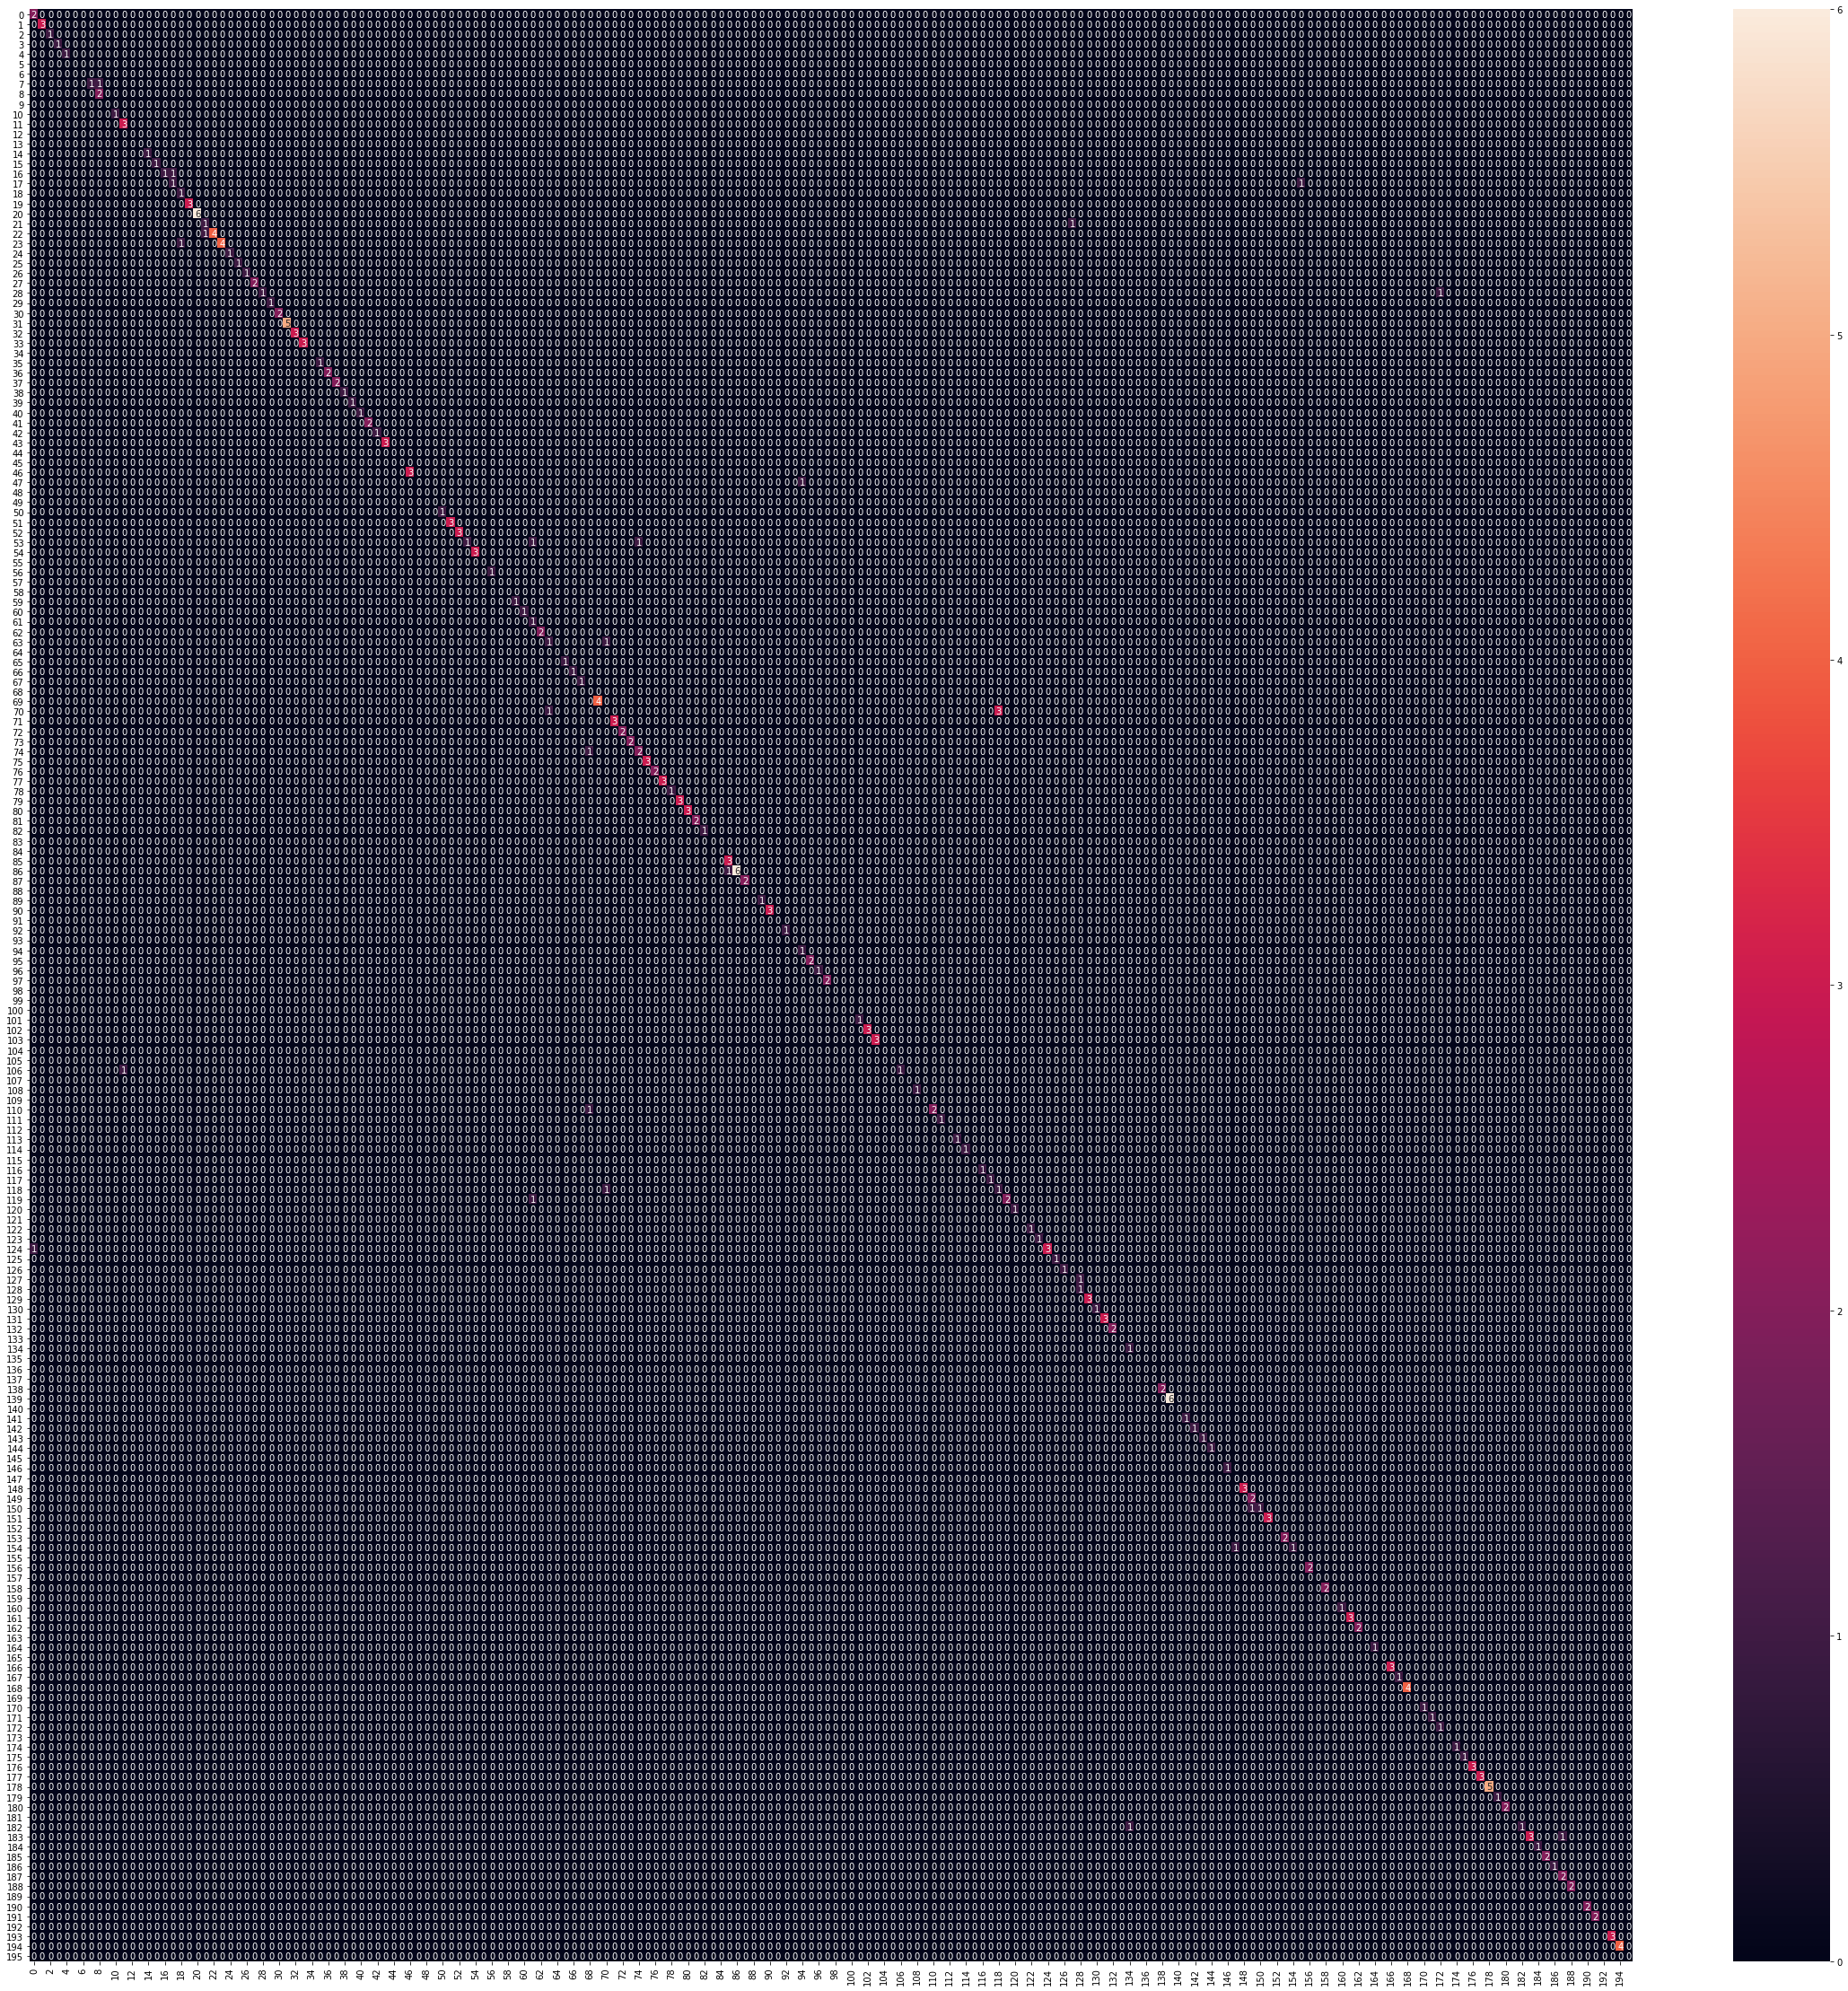

In [28]:
df_cm = pd.DataFrame(cm, index = [i for i in range(0, 196)],
                  columns = [i for i in range(0, 196)])
plt.figure(figsize = (40,40))
sn.heatmap(df_cm, annot=True)

Precision

In [28]:
precision_score(fact_labels, pred_labels, average='weighted') 

0.9372222222222223

Recall

In [29]:
recall_score(fact_labels, pred_labels, average='weighted') 

0.91

In [30]:
f1_score(fact_labels, pred_labels, average='weighted') 

0.9129458689458689